# Clasificador de Imagenes

En esta notebook realizamos un clasificador de images para el Obligatorio de Machine Learning en produccion

## Importacion de librerias y conexion con S3

In [1]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.3 MB/s eta 0:00:00


In [2]:
!pip install torchinfo

In [3]:
import boto3
import pandas as pd
import io
from io import StringIO
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import multiprocessing
import os

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode
from torchinfo import summary

from utils import (
    train,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
    evaluate,
    plot_taining
)


In [4]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
multiprocessing.cpu_count()

2

In [5]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Usando {DEVICE}")

NUM_WORKERS = max(os.cpu_count() - 1, 1)  # número de workers para cargar los datos
BATCH_SIZE = 32  # tamaño del batch

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Usando cuda
Device: cuda
Num Workers: 1


### Configuracion de Credenciales

In [ ]:
aws_access_key_id = ''
aws_secret_access_key = ''
aws_session_token = ''

session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    aws_session_token=aws_session_token
)
s3 = session.client('s3')


## Analisis Exploratorio

En este apartado se realiza el anailisi exploratorio comenzando con:

* evaluacion sobre el tamaño de las imagenes
* El balance entre clases

### Leer Datos desde S3

In [7]:
bucket_name = '1000-imagenes-scrapper-obligatorio-ml'
csv_key = 'scraped_data/results/etiquetas_octogonos.csv'

csv_obj = s3.get_object(Bucket=bucket_name, Key=csv_key)
csv_data = csv_obj['Body'].read().decode('utf-8')


df = pd.read_csv(StringIO(csv_data))
print(df.head())


                                        image         label
0  data/scraped_data/images/201109/201109.jpg  sin_octogono
1  data/scraped_data/images/210208/210208.jpg  sin_octogono
2  data/scraped_data/images/211683/211683.jpg  sin_octogono
3  data/scraped_data/images/211684/211684.jpg  sin_octogono
4  data/scraped_data/images/220350/220350.jpg  con_octogono


### Distribucion de clases

In [8]:
print("Primeras filas:")
print(df.head())

print("\nInfo general:")
print(df.info())

print("\nDistribución de clases:")
print(df['label'].value_counts())

print("\nCantidad total de imágenes:", len(df))
print("\nCantidad de rutas únicas:", df['image'].nunique())


Primeras filas:
                                        image         label
0  data/scraped_data/images/201109/201109.jpg  sin_octogono
1  data/scraped_data/images/210208/210208.jpg  sin_octogono
2  data/scraped_data/images/211683/211683.jpg  sin_octogono
3  data/scraped_data/images/211684/211684.jpg  sin_octogono
4  data/scraped_data/images/220350/220350.jpg  con_octogono

Info general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   777 non-null    object
 1   label   777 non-null    object
dtypes: object(2)
memory usage: 12.3+ KB
None

Distribución de clases:
label
sin_octogono    615
con_octogono    162
Name: count, dtype: int64

Cantidad total de imágenes: 777

Cantidad de rutas únicas: 777


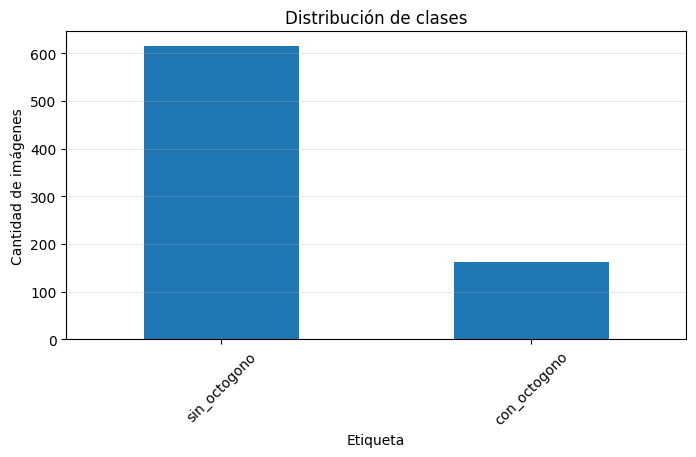

In [9]:
conteo_clases = df['label'].value_counts()


plt.figure(figsize=(8,4))
conteo_clases.plot(kind='bar', rot=45)
plt.title('Distribución de clases')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de imágenes')
plt.grid(axis='y', alpha=0.3)
plt.show()

### Visualizacion randomica

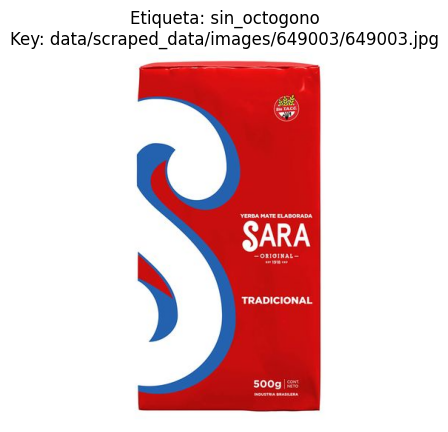

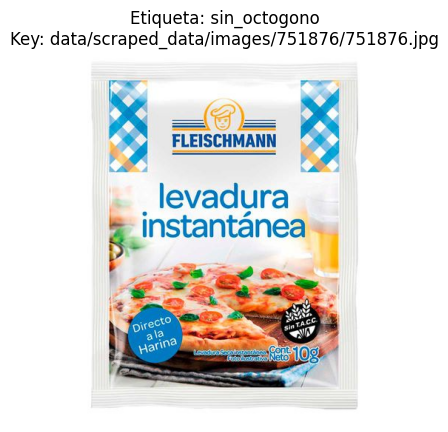

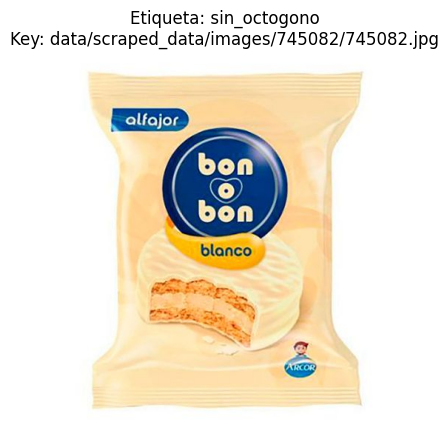

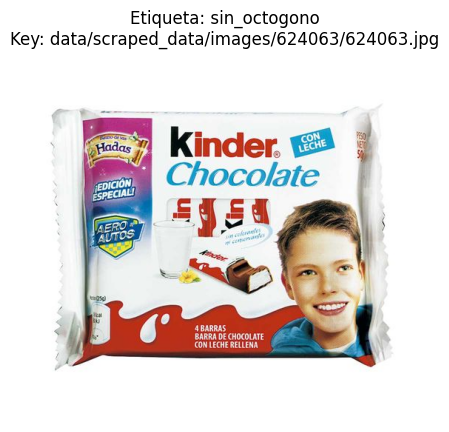

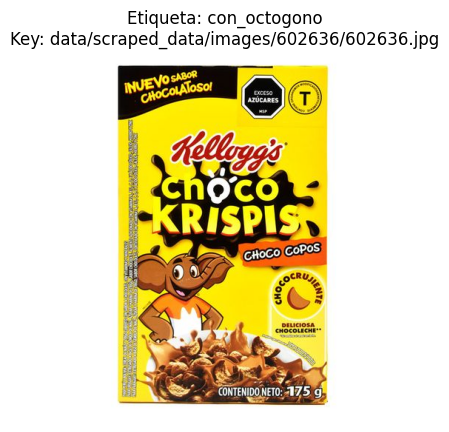

In [10]:
# N imágenes aleatorias del dataframe
N = 5
muestras = df.sample(N)

for i, row in muestras.iterrows():
    img_key = row['image']
    etiqueta = row['label']
    obj = s3.get_object(Bucket=bucket_name, Key=img_key)
    img_bytes = obj['Body'].read()
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    plt.figure()
    plt.imshow(img)
    plt.title(f"Etiqueta: {etiqueta}\nKey: {img_key}")
    plt.axis('off')
    plt.show()


### Distribucion de los tamaños

In [11]:
muestra = df.sample(777) if len(df) > 777 else df

sizes = []

for _, row in muestra.iterrows():
    img_key = row['image']
    try:
        obj = s3.get_object(Bucket=bucket_name, Key=img_key)
        img_bytes = obj['Body'].read()
        img = Image.open(io.BytesIO(img_bytes))
        # Guardar como tupla (ancho, alto)
        sizes.append(img.size)
    except Exception as e:
        pass

# Contar dimensiones
size_counts = Counter(sizes)

# Agrupar tamaños con pocas ocurrencias como "Otras"
grouped_size_counts = {'Otras': 0}
filtered_size_counts = {}

for k, v in size_counts.items():
    if v < 5:  # umbral configurable
        grouped_size_counts['Otras'] += v
    else:
        filtered_size_counts[k] = v

filtered_size_counts.update(grouped_size_counts)

# Convertí a etiquetas tipo "500x500"
size_labels = [f"{size[0]}x{size[1]}" if size != 'Otras' else 'Otras' for size in filtered_size_counts.keys()]
size_frequencies = list(filtered_size_counts.values())

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(size_labels, size_frequencies, color='skyblue', edgecolor='black')
plt.title('Frecuencia de Dimensiones de Imágenes (sample)')
plt.ylabel('Dimensiones (ancho x alto)')
plt.xlabel('Frecuencia')
plt.tight_layout()
plt.show()




KeyboardInterrupt: 

In [ ]:
errores = []
for i, row in df.iterrows():
    img_key = row['image']
    try:
        obj = s3.get_object(Bucket=bucket_name, Key=img_key)
        img_bytes = obj['Body'].read()
        img = Image.open(io.BytesIO(img_bytes))
    except Exception as e:
        errores.append((img_key, str(e)))
    if len(errores) > 10:
        break
print(errores)


## Dataset, DataLoaders, division y transformacion


### Dataset

In [12]:
class S3ImageDataset(Dataset):
    def __init__(self, df, bucket_name, s3_client, transform=None):
        self.df = df.reset_index(drop=True)
        self.bucket = bucket_name
        self.s3 = s3_client
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_key = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']

        # Leer imagen desde S3
        obj = self.s3.get_object(Bucket=self.bucket, Key=img_key)
        img_bytes = obj['Body'].read()
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Clasificación binaria: convertir a 0 (sin_octogonos) o 1 (con_octogonos)
        if isinstance(label, str):
            label = 1 if label.strip().lower() == "con_octogono" else 0

        return img, label


### DataLoaders

In [13]:
def get_data_loaders(df, train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):


  #Primero: dividir el dataset
  train_df, intermedio_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=SEED)
  val_df, test_df = train_test_split(intermedio_df, test_size=0.5, stratify=intermedio_df['label'], random_state=SEED)

  #Segundo: Realizar las transformadas sobre los sub dataset
  dataset_train = S3ImageDataset(train_df, bucket_name, s3, transform=train_transf)
  dataset_val = S3ImageDataset(val_df, bucket_name, s3, transform=test_transf)
  dataset_test = S3ImageDataset(test_df, bucket_name, s3, transform=test_transf)

  #Tercero: Crear los dataloaders
  train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
  val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
  test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

  return train_loader, val_loader, test_loader


### Transformaciones

In [14]:
train_transforms_1 = T.Compose(
    [
        T.Resize((500, 500)),
        T.ToTensor(),
    ]
)

train_transforms_2 = T.Compose(
    [
        T.Resize((500, 500)),
        T.RandomRotation(30),
        T.ToTensor(),
    ]
)

train_transforms_3 = T.Compose(
    [
         T.Resize((500, 500)),
         T.RandomHorizontalFlip(p=0.5),
         T.ToTensor(),
     ]
)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Modelo

## Modelo 1 - LeNet - Imagenes de 500x500

In [15]:
BATCH_SIZE=32

In [16]:
class LeNet_1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet_1, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        # Para imágenes de 500x500:
        self.f6 = nn.Linear(in_features=120*118*118, out_features=84)
        self.output = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.tanh(self.c1(x))
        x = self.s2(x)
        x = F.tanh(self.c3(x))
        x = self.s4(x)
        x = F.tanh(self.c5(x))
        x = x.flatten(start_dim=1)
        x = F.tanh(self.f6(x))
        x = self.output(x)
        return x

summary(LeNet_1(3, 2), input_size=(BATCH_SIZE, 3, 500, 500))


Layer (type:depth-idx)                   Output Shape              Param #
LeNet_1                                  [32, 2]                   --
├─Conv2d: 1-1                            [32, 6, 496, 496]         456
├─AvgPool2d: 1-2                         [32, 6, 248, 248]         --
├─Conv2d: 1-3                            [32, 16, 244, 244]        2,416
├─AvgPool2d: 1-4                         [32, 16, 122, 122]        --
├─Conv2d: 1-5                            [32, 120, 118, 118]       48,120
├─Linear: 1-6                            [32, 84]                  140,354,004
├─Linear: 1-7                            [32, 2]                   170
Total params: 140,405,166
Trainable params: 140,405,166
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 34.12
Input size (MB): 96.00
Forward/backward pass size (MB): 1049.51
Params size (MB): 561.62
Estimated Total Size (MB): 1707.13

## Entrenamiento

In [17]:
LR = 0.001
EPOCHS = 8
CRITERION = nn.CrossEntropyLoss().to(DEVICE)

In [18]:
letnet_model_1 = LeNet_1(3, 2).to(DEVICE)
optimizer = optim.Adam(letnet_model_1.parameters(), lr=LR)


train_loader, val_loader, test_loader = get_data_loaders(
    df, train_transforms_1, train_transforms_1
)

In [19]:
train_loader

Epoch: 001 | Train Loss: 0.94293 | Val Loss: 0.72844
Epoch: 002 | Train Loss: 0.58178 | Val Loss: 0.52710
Epoch: 003 | Train Loss: 0.52215 | Val Loss: 0.52151
Epoch: 004 | Train Loss: 0.51553 | Val Loss: 0.52291
Epoch: 005 | Train Loss: 0.51492 | Val Loss: 0.52151
Epoch: 006 | Train Loss: 0.51221 | Val Loss: 0.52180
Detener entrenamiento en la época 5, la mejor pérdida fue 0.52151


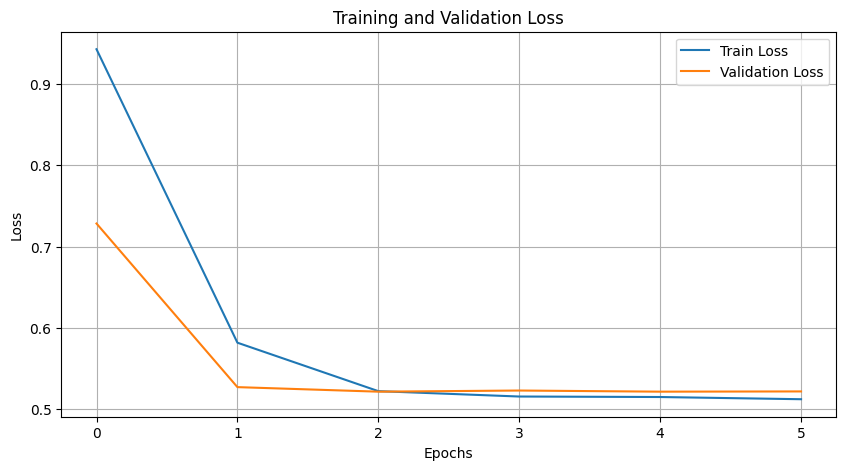

In [20]:
# con reshape de 500x500 y sin balnacear pesos
train_errors_ln_nda, val_errors_ln_nda = train(
    model=letnet_model_1,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=3,
    epochs=EPOCHS,
)

plot_taining(train_errors_ln_nda, val_errors_ln_nda)

In [21]:
model_calassification_report(letnet_model_1, test_loader, DEVICE, 2)

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
torch.save(letnet_model_1.state_dict(), 'letnet_model_1.pth')

In [23]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
import shutil

# Ruta destino (puede ser la que quieras dentro de tu Drive)
destino = '/content/drive/My Drive/Colab Notebooks/letnet_model_1.pth'

# Ruta origen (donde está el archivo)
origen = '/content/letnet_model_1.pth'

# Copiá el archivo
shutil.copy(origen, destino)


'/content/drive/My Drive/Colab Notebooks/letnet_model_1.pth'

# Wights and baise